# Ramp Optimization Examples

This notebook outlines an example to optimize the ramp settings for a few different types of observations.

In these types of optimizations, we must consider observations constraints such as saturation levels, SNR requirements, and limits on acquisition time.

**Note**: The reported acquisition time does not include obsevatory and instrument-level overheads, such as slew times, filter changes, script compilations, etc. It only includes detector readout times (including reset frames).

In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import S, jl_poly_fit
from pynrc.pynrc_core import table_filter

pynrc.setup_logging('WARNING', verbose=False)

from astropy.table import Table

# Progress bar
from tqdm.auto import tqdm, trange

## Example 1: M-Dwarf companion (imaging vs coronagraphy)

We want to observe an M-Dwarf companion (K=18 mag) in the vicinity of a brighter F0V (K=13 mag) in the F430M filter. Assume the M-Dwarf flux is not significantly impacted by the brighter PSF (ie., in the background limited regime). In this scenario, the F0V star will saturate much more quickly compared to the fainter companion, so it limits which ramp settings we can use.

We will test a couple different types of observations (direct imaging vs coronagraphy).

In [3]:
# Get stellar spectra and normalize at K-Band
# The stellar_spectrum convenience function creates a Pysynphot spectrum
bp_k = S.ObsBandpass('k')
sp_M2V = pynrc.stellar_spectrum('M2V', 18, 'vegamag', bp_k)#, catname='ck04models')
sp_F0V = pynrc.stellar_spectrum('F0V', 13, 'vegamag', bp_k)#, catname='ck04models')

In [4]:
# Initiate a NIRCam observation
nrc = pynrc.NIRCam(filter='F430M', wind_mode='WINDOW', xpix=160, ypix=160)

In [5]:
# Set some observing constraints
# Let's assume we want photometry on the primary to calibrate the M-Dwarf for direct imaging
#  - Set well_frac_max=0.75
# Want a SNR~100 in the F430M filter
#  - Set snr_goal=100
res = nrc.ramp_optimize(sp_M2V, sp_bright=sp_F0V, snr_goal=100, well_frac_max=0.75, verbose=True)

BRIGHT1
BRIGHT2
DEEP2
DEEP8
MEDIUM2
MEDIUM8
RAPID
SHALLOW2
SHALLOW4
 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
DEEP8         7    4     35.67    142.66    143.80     99.3    0.628    8.277
DEEP8         7    5     35.67    178.33    179.75    111.0    0.628    8.277
DEEP2         8    4     39.57    158.27    159.40     98.5    0.696    7.804
DEEP2         8    5     39.57    197.83    199.25    110.2    0.696    7.804
DEEP8         5    7     24.52    171.64    173.63    101.4    0.432    7.697
MEDIUM8       8    8     21.73    173.87    176.14    100.5    0.383    7.575
MEDIUM8       8    9     21.73    195.61    198.16    106.6    0.383    7.575
MEDIUM2      10    7     25.63    179.44    181.43     98.6    0.451    7.322
...         ...  ...       ...       ...       ...      ...      ...      ...
RAPID        10  555      2.79   1546.45   1703.96    101.5    0.049    2.

In [6]:
# Print the Top 2 settings for each readout pattern
res2 = table_filter(res, 2)
print(res2)

 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
RAPID        10  539      2.79   1501.87   1654.84    100.0    0.049    2.458
RAPID        10  540      2.79   1504.66   1657.91    100.1    0.049    2.458
BRIGHT1      10  145      5.29    767.65    808.80     99.8    0.093    3.509
BRIGHT1      10  146      5.29    772.95    814.38    100.1    0.093    3.509
BRIGHT2      10   93      5.57    518.27    544.66     99.7    0.098    4.270
BRIGHT2      10   94      5.57    523.84    550.52    100.2    0.098    4.270
SHALLOW2     10   20     13.10    261.92    267.60     99.6    0.230    6.089
SHALLOW2     10   21     13.10    275.02    280.98    102.1    0.230    6.089
SHALLOW4     10   16     13.65    218.45    222.99     99.7    0.240    6.675
SHALLOW4     10   17     13.65    232.11    236.93    102.8    0.240    6.675
MEDIUM2      10    7     25.63    179.44    181.43     98.6    0

In [7]:
# Do the same thing, but for coronagraphic mask instead
nrc = pynrc.NIRCam(filter='F430M', image_mask='MASK430R', pupil_mask='CIRCLYOT', 
                   wind_mode='WINDOW', xpix=320, ypix=320)

# We assume that longer ramps will give us the best SNR for time
patterns = ['MEDIUM8', 'DEEP8']
res = nrc.ramp_optimize(sp_M2V, sp_bright=sp_F0V, snr_goal=100, 
                        patterns=patterns, even_nints=True)

# Take the Top 2 settings for each readout pattern
res2 = table_filter(res, 2)
print(res2)

 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
MEDIUM8      10   94    104.77   9848.00   9950.36     99.6    0.001    0.998
MEDIUM8      10   96    104.77  10057.53  10162.07    100.7    0.001    0.998
DEEP8        20   14    414.79   5807.03   5822.27    104.6    0.003    1.370
DEEP8        19   14    393.41   5507.69   5522.94    101.2    0.003    1.362


**RESULTS**

Based on these two comparisons, it looks like direct imaging is much more efficient in getting to the requisite SNR. In addition, direct imaging gives us a photometric comparison source that is inaccessible when occulting the primary with the coronagraph masks. **Of course, this assumes the companion exists in the background limit as opposed to the contrast limit.**

## Example 2: Exoplanet Coronagraphy

We want to observe GJ 504 for an hour in the F444W filter using the MASK430R coronagraph. 
 - What is the optimal ramp settings to maximize the SNR of GJ 504b?
 - What is the final background sensitivity limit?

In [8]:
# Get stellar spectra and normalize at K-Band
# The stellar_spectrum convenience function creates a Pysynphot spectrum
bp_k = pynrc.bp_2mass('ks')
sp_G0V = pynrc.stellar_spectrum('G0V', 4, 'vegamag', bp_k)

# Choose a representative planet spectrum
planet = pynrc.planets_sb12(atmo='hy3s', mass=8, age=200, entropy=8, distance=17.5)
sp_pl = planet.export_pysynphot()

# Renormalize to F360M = 18.8
bp_l = pynrc.read_filter('F360M') # 
sp_pl = sp_pl.renorm(18.8, 'vegamag', bp_l)

In [9]:
# Initiate a NIRCam observation
nrc = pynrc.NIRCam(filter='F444W', pupil_mask='CIRCLYOT', image_mask='MASK430R', 
                   wind_mode='WINDOW', xpix=320, ypix=320)

In [10]:
# Set even_nints=True assume 2 roll angles
res = nrc.ramp_optimize(sp_pl, sp_bright=sp_G0V, tacq_max=3600, tacq_frac=0.05, 
                        even_nints=True, verbose=True)

BRIGHT1
BRIGHT2
DEEP2
DEEP8
MEDIUM2
MEDIUM8
RAPID
SHALLOW2
SHALLOW4
 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
DEEP2        17   10    344.23   3442.31   3453.20    672.8    0.777   11.448
DEEP2        16   10    322.85   3228.50   3239.39    651.5    0.728   11.446
DEEP2        16   12    322.85   3874.20   3887.27    713.7    0.728   11.446
DEEP2        15   12    301.47   3617.63   3630.70    689.4    0.680   11.440
DEEP2        14   12    280.09   3361.06   3374.13    664.0    0.632   11.431
DEEP8        17   10    350.65   3506.45   3517.34    676.2    0.791   11.402
DEEP8        16   10    329.26   3292.64   3303.53    655.3    0.743   11.401
DEEP8        15   12    307.88   3694.60   3707.67    694.1    0.695   11.398
...         ...  ...       ...       ...       ...      ...      ...      ...
BRIGHT2      10  162     21.38   3463.69   3640.10    518.1    0.048    8.

In [11]:
# Take the Top 2 settings for each readout pattern
res2 = table_filter(res, 2)
print(res2)

 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
RAPID        10  304     10.69   3249.88   3580.93    358.9    0.024    5.997
RAPID        10  306     10.69   3271.26   3604.48    360.1    0.024    5.997
BRIGHT1      10  166     20.31   3371.75   3552.52    463.1    0.046    7.768
BRIGHT1      10  168     20.31   3412.38   3595.32    465.8    0.046    7.768
BRIGHT2      10  158     21.38   3378.17   3550.22    511.7    0.048    8.587
BRIGHT2      10  160     21.38   3420.93   3595.16    514.9    0.048    8.587
SHALLOW2     10   68     50.24   3416.65   3490.70    606.1    0.113   10.258
SHALLOW2     10   70     50.24   3517.14   3593.37    615.0    0.113   10.258
SHALLOW4     10   66     52.38   3457.28   3529.15    619.9    0.118   10.434
SHALLOW4     10   68     52.38   3562.04   3636.09    629.2    0.118   10.434
MEDIUM2      10   34     98.35   3343.96   3380.98    638.0    0

In [12]:
# The SHALLOWs, DEEPs, and MEDIUMs are very similar for SNR and efficiency.
# Let's go with SHALLOW2 for more GROUPS & INTS 
# MEDIUM8 would be fine as well.
nrc.update_detectors(read_mode='SHALLOW2', ngroup=10, nint=70)

keys = list(nrc.multiaccum_times.keys())
keys.sort()
for k in keys:
    print("{:<10}: {: 12.5f}".format(k, nrc.multiaccum_times[k]))

t_acq     :   3593.36880
t_exp     :   3517.14160
t_frame   :      1.06904
t_group   :      5.34520
t_int     :     50.24488
t_int_tot1:     51.33384
t_int_tot2:     51.33384


In [13]:
# Background sensitivity (5 sigma)
sens_dict = nrc.sensitivity(nsig=5, units='vegamag', verbose=True)

Point Source Sensitivity (5-sigma): 21.43 vegamag
Surface Brightness Sensitivity (5-sigma): 22.74 vegamag/arcsec^2


## Example 3: Single-Object Grism Spectroscopy

Similar to the above, but instead we want to obtain a slitless grism spectrum of a K=12 mag M0V dwarf. Each grism resolution element should have SNR~100.

In [14]:
# M0V star normalized to K=12 mags
bp_k = S.ObsBandpass('k')
sp_M0V = pynrc.stellar_spectrum('M0V', 12, 'vegamag', bp_k)

In [15]:
nrc = pynrc.NIRCam(filter='F444W', pupil_mask='GRISMR', wind_mode='STRIPE', ypix=128)

In [16]:
# Set a minimum of 10 integrations to be robust against cosmic rays
# Also set a minimum of 10 groups for good ramp sampling
res = nrc.ramp_optimize(sp_M0V, snr_goal=100, nint_min=10, ng_min=10, verbose=True)

BRIGHT1
BRIGHT2
DEEP2
DEEP8
MEDIUM2
MEDIUM8
RAPID
SHALLOW2
SHALLOW4
 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
DEEP2        10   10    123.03   1230.27   1237.08    332.4    0.071    9.449
DEEP8        10   10    127.08   1270.82   1277.64    336.0    0.074    9.399
MEDIUM2      10   10     62.19    621.89    628.71    231.2    0.036    9.219
MEDIUM8      10   10     66.25    662.45    669.27    236.1    0.038    9.127
SHALLOW4     10   10     33.12    331.23    338.04    161.8    0.019    8.802
SHALLOW2     10   10     31.77    317.71    324.52    157.6    0.018    8.746
BRIGHT2      10   12     13.52    162.23    170.41     98.8    0.008    7.567
BRIGHT2      10   13     13.52    175.75    184.61    102.8    0.008    7.567
BRIGHT1      10   15     12.84    192.65    202.87    100.0    0.007    7.021
BRIGHT1      10   16     12.84    205.49    216.40    103.3    0.007    7.

In [17]:
# Print the Top 2 settings for each readout pattern
res2 = table_filter(res, 2)
print(res2)

 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
RAPID        10   42      6.76    283.91    312.52     99.0    0.004    5.599
RAPID        10   43      6.76    290.67    319.96    100.2    0.004    5.599
BRIGHT1      10   15     12.84    192.65    202.87    100.0    0.007    7.021
BRIGHT1      10   16     12.84    205.49    216.40    103.3    0.007    7.021
BRIGHT2      10   12     13.52    162.23    170.41     98.8    0.008    7.567
BRIGHT2      10   13     13.52    175.75    184.61    102.8    0.008    7.567
SHALLOW2     10   10     31.77    317.71    324.52    157.6    0.018    8.746
SHALLOW4     10   10     33.12    331.23    338.04    161.8    0.019    8.802
MEDIUM2      10   10     62.19    621.89    628.71    231.2    0.036    9.219
MEDIUM8      10   10     66.25    662.45    669.27    236.1    0.038    9.127
DEEP2        10   10    123.03   1230.27   1237.08    332.4    0

In [18]:
# Let's say we choose SHALLOW4, NGRP=10, NINT=10
# Update detector readout
nrc.update_detectors(read_mode='SHALLOW4', ngroup=10, nint=10)

keys = list(nrc.multiaccum_times.keys())
keys.sort()
for k in keys:
    print("{:<10}: {: 12.5f}".format(k, nrc.multiaccum_times[k]))

t_acq     :    338.04264
t_exp     :    331.22530
t_frame   :      0.67597
t_group   :      3.37985
t_int     :     33.12253
t_int_tot1:     33.80374
t_int_tot2:     33.80374


In [19]:
# Print final wavelength-dependent SNR
# For spectroscopy, the snr_goal is the median over the bandpass
snr_dict = nrc.sensitivity(sp=sp_M0V, forwardSNR=True, units='mJy', verbose=True)

F444W SNR for M0V source
   Wave      SNR    Flux (mJy)
--------- --------- ----------
     3.80      9.52       4.54
     3.90    230.66       4.34
     4.00    246.18       4.15
     4.10    235.68       3.97
     4.20    221.71       3.73
     4.30    197.92       3.26
     4.40    184.55       3.19
     4.50    169.03       2.85
     4.60    154.66       2.79
     4.70    139.31       2.63
     4.80    131.21       2.70
     4.90    115.05       2.60
     5.00     57.52       2.38
     5.10      1.30       2.46


**Mock observed spectrum**

Create a series of ramp integrations based on the current NIRCam settings. The gen_exposures() function creates a series of mock observations in raw DMS format by default. By default, it's point source objects centered in the observing window.

In [20]:
# Ideal spectrum and wavelength solution
wspec, imspec = nrc.calc_psf_from_coeff(sp=sp_M0V, return_hdul=False, return_oversample=False)

# Resize to detector window
nx = nrc.det_info['xpix']
ny = nrc.det_info['ypix']

# Shrink/expand nx (fill value of 0)
# Then shrink to a size excluding wspec=0
# This assumes simulated spectrum is centered
imspec = nrc_utils.pad_or_cut_to_size(imspec, (ny,nx))
wspec = nrc_utils.pad_or_cut_to_size(wspec, nx)

In [21]:
# Add simple zodiacal background
im_slope = imspec + nrc.bg_zodi()

In [22]:
# Create a series of ramp integrations based on the current NIRCam settings
# Output is a single HDUList with 10 INTs
# Ignore detector non-linearity to return output in e-/sec
kwargs = {
        'apply_nonlinearity' : False,
        'apply_flats'        : False,
}
res = nrc.simulate_level1b('M0V Target', 0, 0, '2023-01-01', '12:00:00', 
                           im_slope=im_slope, return_hdul=True, **kwargs)

PPC Amps:   0%|          | 0/4 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

PPC Amps:   0%|          | 0/4 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Ramps:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

[     pynrc:WARNING] Source RA, Dec = (0.0, 0.0) deg is not visible on 2023-01-01!


In [23]:
res.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     117   ()      
  1  SCI           1 ImageHDU        44   (2048, 128, 10, 10)   uint16   
  2  ZEROFRAME     1 ImageHDU        12   (2048, 128, 10)   uint16   
  3  GROUP         1 BinTableHDU     36   100R x 13C   ['I', 'I', 'I', 'J', 'I', '26A', 'I', 'I', 'I', 'I', '36A', 'D', 'D']   
  4  INT_TIMES     1 BinTableHDU     24   10R x 7C   ['J', 'D', 'D', 'D', 'D', 'D', 'D']   


In [24]:
tvals = nrc.Detector.times_group_avg

header = res['PRIMARY'].header
data_all = res['SCI'].data
slope_list = []
for data in tqdm(data_all):
    ref = pynrc.ref_pixels.NRC_refs(data, header, DMS=True, do_all=False)
    ref.calc_avg_amps()
    ref.correct_amp_refs()

    # Linear fit to determine slope image
    cf = jl_poly_fit(tvals, ref.data, deg=1)
    slope_list.append(cf[1])
    
# Create a master averaged slope image
slopes_all = np.array(slope_list)
slope_sim = slopes_all.mean(axis=0) * nrc.Detector.gain

  0%|          | 0/10 [00:00<?, ?it/s]

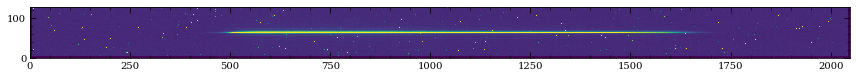

In [25]:
fig, ax = plt.subplots(1,1, figsize=(12,3))
ax.imshow(slope_sim, vmin=0, vmax=10)

fig.tight_layout()

In [26]:
ind = wspec>0

# Estimate background emission and subtract from slope_sim
bg = np.median(slope_sim[:,~ind])
slope_sim -= bg

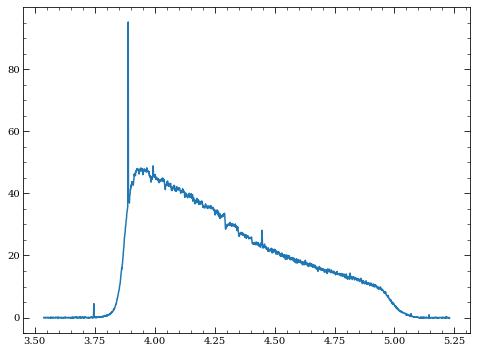

In [27]:
ind = wspec>0
plt.plot(wspec[ind], slope_sim[63,ind])

In [28]:
# Extract 2 spectral x 5 spatial pixels

# First, cut out the central 5 pixels
wspec_sub = wspec[ind]
sh_new  = (5, len(wspec_sub))
slope_sub = nrc_utils.pad_or_cut_to_size(slope_sim, sh_new)
slope_sub_ideal = nrc_utils.pad_or_cut_to_size(imspec, sh_new)

# Sum along the spatial axis
spec = slope_sub.sum(axis=0)
spec_ideal = slope_sub_ideal.sum(axis=0)
spec_ideal_rebin = nrc_utils.frebin(spec_ideal, scale=0.5, total=False)

# Build a quick RSRF from extracted ideal spectral slope
sp_M0V.convert('mjy')
rsrf = spec_ideal / sp_M0V.sample(wspec_sub*1e4)

# Rebin along spectral direction
wspec_rebin = nrc_utils.frebin(wspec_sub, scale=0.5, total=False)
spec_rebin_cal = nrc_utils.frebin(spec/rsrf, scale=0.5, total=False)

In [29]:
# Expected noise per extraction element
snr_interp = np.interp(wspec_rebin, snr_dict['wave'], snr_dict['snr'])
_spec_rebin = spec_ideal_rebin / snr_interp
_spec_rebin_cal = _spec_rebin / nrc_utils.frebin(rsrf, scale=0.5, total=False)

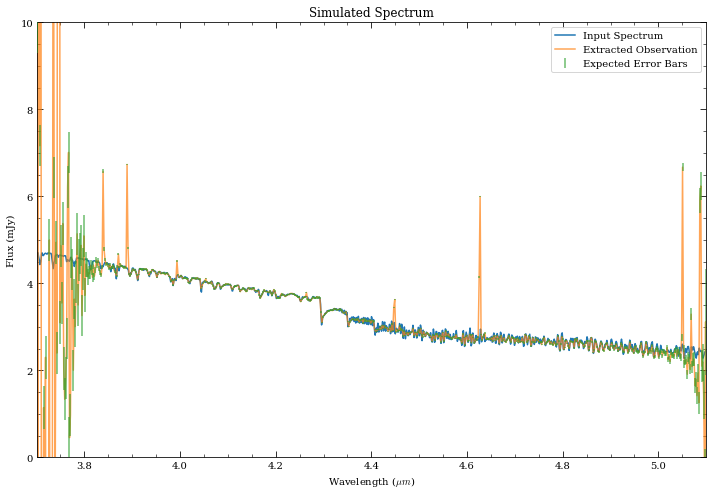

In [30]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.plot(sp_M0V.wave/1e4, sp_M0V.flux, label='Input Spectrum')
ax.plot(wspec_rebin, spec_rebin_cal, alpha=0.7, label='Extracted Observation')
ax.errorbar(wspec_rebin, spec_rebin_cal, yerr=_spec_rebin_cal, zorder=3,
            fmt='none', label='Expected Error Bars', alpha=0.7, color='C2')

ax.set_ylim([0,10])
ax.set_xlim([3.7,5.1])

ax.set_xlabel('Wavelength ($\mu m$)')
ax.set_ylabel('Flux (mJy)')
ax.set_title('Simulated Spectrum')

ax.legend(loc='upper right');

## Example 4: Exoplanet Transit Spectroscopy

Let's say we want to observe an exoplanet transit using NIRCam grisms in the F322W2 filter. 

We assume a 2.1-hour transit duration for a K6V star (K=8.4 mag).

In [31]:
nrc = pynrc.NIRCam('F322W2', pupil_mask='GRISM0', wind_mode='STRIPE', ypix=64)

In [32]:
# K6V star at K=8.4 mags
bp_k = S.ObsBandpass('k')
sp_K6V = pynrc.stellar_spectrum('K6V', 8.4, 'vegamag', bp_k)

In [33]:
# Constraints
well     = 0.5        # Keep well below 50% full
tacq     = 2.1*3600.  # 2.1 hour transit duration
ng_max   = 30         # Transit spectroscopy allows for up to 30 groups per integrations
nint_max = int(1e6)   # Effectively no limit on number of integrations

# Let's bin the spectrum to R~100
# dw_bin is a passable parameter for specifiying spectral bin sizes
R = 100
dw_bin = (nrc.bandpass.avgwave() / 10000) / R

In [34]:
res = nrc.ramp_optimize(sp_K6V, tacq_max=tacq, nint_max=nint_max, 
                        ng_min=10, ng_max=ng_max, well_frac_max=well, 
                        dw_bin=dw_bin, verbose=True)

BRIGHT1
BRIGHT2
DEEP2
DEEP8
MEDIUM2
MEDIUM8
RAPID
SHALLOW2
SHALLOW4
 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
BRIGHT1      24  460     16.01   7363.99   7523.08  30955.5    0.494  356.894
BRIGHT1      24  461     16.01   7380.00   7539.44  30989.1    0.494  356.894
BRIGHT1      24  462     16.01   7396.01   7555.79  31022.7    0.494  356.894
BRIGHT1      24  463     16.01   7412.01   7572.15  31056.3    0.494  356.894
BRIGHT1      24  464     16.01   7428.02   7588.50  31089.8    0.494  356.894
BRIGHT2      23  470     15.67   7363.99   7526.54  30623.8    0.484  352.989
BRIGHT2      23  471     15.67   7379.66   7542.56  30656.4    0.484  352.989
BRIGHT2      23  472     15.67   7395.32   7558.57  30688.9    0.484  352.989
...         ...  ...       ...       ...       ...      ...      ...      ...
SHALLOW2     10  462     16.01   7396.01   7555.79  30678.0    0.494  352.

In [35]:
# Print the Top 2 settings for each readout pattern
res2 = table_filter(res, 2)
print(res2)

 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
RAPID        30  713     10.22   7285.65   7532.24  30585.0    0.315  352.408
RAPID        30  714     10.22   7295.87   7542.81  30606.5    0.315  352.408
BRIGHT1      24  460     16.01   7363.99   7523.08  30955.5    0.494  356.894
BRIGHT1      24  461     16.01   7380.00   7539.44  30989.1    0.494  356.894
BRIGHT2      23  470     15.67   7363.99   7526.54  30623.8    0.484  352.989
BRIGHT2      23  471     15.67   7379.66   7542.56  30656.4    0.484  352.989
SHALLOW2     10  460     16.01   7363.99   7523.08  30611.6    0.494  352.929
SHALLOW2     10  461     16.01   7380.00   7539.44  30644.8    0.494  352.929


In [36]:
# Even though BRIGHT1 has a slight efficiency preference over RAPID 
# and BRIGHT2, we decide to choose RAPID, because we are convinced 
# that saving all data (and no coadding) is a better option. 
# If APT informs you that the data rates or total data shorage is 
# an issue, you can select one of the other options.

# Update to RAPID, ngroup=30, nint=700 and plot PPM
nrc.update_detectors(read_mode='RAPID', ngroup=30, nint=700)
snr_dict = nrc.sensitivity(sp=sp_K6V, dw_bin=dw_bin, forwardSNR=True, units='Jy')
wave = np.array(snr_dict['wave'])
snr  = np.array(snr_dict['snr'])

# Let assume bg subtraction of something with similar noise
snr /= np.sqrt(2.)
ppm = 1e6 / snr

# NOTE: We have up until now neglected to include a "noise floor"
# which represents the expected minimum achievable ppm from
# unknown systematics. To first order, this can be added in 
# quadrature to the calculated PPM.
noise_floor = 30 # in ppm
ppm_floor = np.sqrt(ppm**2 + noise_floor**2)

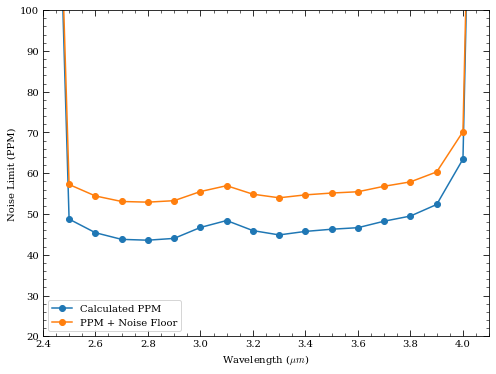

In [37]:
plt.plot(wave, ppm, marker='o', label='Calculated PPM')
plt.plot(wave, ppm_floor, marker='o', label='PPM + Noise Floor')
plt.xlabel('Wavelength ($\mu m$)')
plt.ylabel('Noise Limit (PPM)')
plt.xlim([2.4,4.1])
plt.ylim([20,100])
plt.legend()

## Example 5: Extended Souce

Expect some faint galaxies of 25 ABMag/arcsec^2 in our field. What is the best we can do with 10,000 seconds of acquisition time? 

In [38]:
# Detection bandpass is F200W
nrc = pynrc.NIRCam(filter='F200W')

# Flat spectrum (in photlam) with ABMag = 25 in the NIRCam bandpass
sp = pynrc.stellar_spectrum('flat', 25, 'abmag', nrc.bandpass)

In [39]:
res = nrc.ramp_optimize(sp, is_extended=True, tacq_max=10000, tacq_frac=0.05, verbose=True)

BRIGHT1
BRIGHT2
DEEP2
DEEP8
MEDIUM2
MEDIUM8
RAPID
SHALLOW2
SHALLOW4
 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
MEDIUM8      10    9   1052.20   9469.83   9555.73     10.5    0.020    0.107
MEDIUM8      10   10   1052.20  10522.03  10618.67     11.1    0.020    0.107
DEEP8         8    5   1589.04   7945.21   7988.16      9.5    0.031    0.106
DEEP8         7    6   1374.31   8245.84   8299.53      9.7    0.026    0.106
MEDIUM8       8   11    837.47   9212.15   9319.52     10.2    0.016    0.106
DEEP8         6    8   1159.57   9276.57   9351.73     10.3    0.022    0.106
MEDIUM8       9   10    944.84   9448.36   9544.99     10.4    0.018    0.106
DEEP8         8    6   1589.04   9534.25   9587.94     10.4    0.031    0.106
...         ...  ...       ...       ...       ...      ...      ...      ...
BRIGHT1      10   49    204.00   9995.93  10511.30      6.6    0.004    0.

In [40]:
# Print the Top 2 settings for each readout pattern
res2 = table_filter(res, 2)
print(res2)

 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
RAPID        10   91    107.37   9770.46  10736.78      4.9    0.002    0.047
RAPID        10   92    107.37   9877.83  10854.88      5.0    0.002    0.047
BRIGHT1      10   47    204.00   9587.94  10081.83      6.5    0.004    0.064
BRIGHT1      10   48    204.00   9791.93  10296.57      6.6    0.004    0.064
BRIGHT2      10   45    214.74   9663.09  10135.52      7.8    0.004    0.077
BRIGHT2      10   46    214.74   9877.83  10360.99      7.9    0.004    0.077
SHALLOW2     10   18    504.63   9083.31   9265.84      9.3    0.010    0.096
SHALLOW2     10   19    504.63   9587.94   9781.20      9.6    0.010    0.096
SHALLOW4     10   18    526.10   9469.83   9652.36     10.1    0.010    0.102
SHALLOW4     10   19    526.10   9995.93  10189.20     10.3    0.010    0.102
MEDIUM2      10    9    987.78   8890.05   8975.94      9.8    0

In [41]:
# MEDIUM8 10 10 looks like a good option
nrc.update_detectors(read_mode='MEDIUM8', ngroup=10, nint=10, verbose=True)

New Ramp Settings
  read_mode  :  MEDIUM8
  nf         :        8
  nd2        :        2
  ngroup     :       10
  nint       :       10
New Detector Settings
  wind_mode  :     FULL
  xpix       :     2048
  ypix       :     2048
  x0         :        0
  y0         :        0
New Ramp Times
  t_group    :  107.368
  t_frame    :   10.737
  t_int      : 1052.203
  t_int_tot1 : 1052.203
  t_int_tot2 : 1062.940
  t_exp      : 10522.035
  t_acq      : 10618.671


In [42]:
# Calculate flux/mag for various nsigma detection limits
tbl = Table(names=('Sigma', 'Point (nJy)',    'Extended (nJy/asec^2)', 
                            'Point (AB Mag)', 'Extended (AB Mag/asec^2)'))
tbl['Sigma'].format = '.0f'
for k in tbl.keys()[1:]:
    tbl[k].format = '.2f'

for sig in [1,3,5,10]:
    snr_dict1 = nrc.sensitivity(nsig=sig, units='nJy', verbose=False)
    snr_dict2 = nrc.sensitivity(nsig=sig, units='abmag', verbose=False)
    tbl.add_row([sig, snr_dict1[0]['sensitivity'], snr_dict1[1]['sensitivity'],
                snr_dict2[0]['sensitivity'], snr_dict2[1]['sensitivity']])

In [43]:
tbl

Sigma,Point (nJy),Extended (nJy/asec^2),Point (AB Mag),Extended (AB Mag/asec^2)
float64,float64,float64,float64,float64
1,1.10,32.05,31.30,27.64
3,3.30,96.57,30.10,26.44
5,5.52,161.67,29.55,25.88
10,11.14,326.99,28.78,25.11
